In [30]:
from pathlib import Path
import requests

In [31]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)
URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL+FILENAME).content
    (PATH/FILENAME).open("wb").write(content)

In [32]:
import pickle
import gzip

with gzip.open((PATH/FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [33]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

In [34]:
# Individiaul data is stored as a flattened row of length 784 (28x28)
# Show image data
import matplotlib.pyplot as plt
import numpy as np

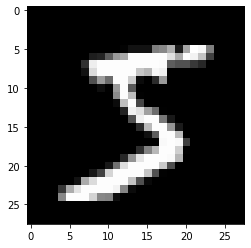

(50000, 784)


In [35]:
plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
try:
    import google.colab
except ImportError:
    plt.show()
print(x_train.shape)

In [36]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())
print(x_train.dtype)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)
torch.float32


# Neural net from scratch (no torch.nn)

In [37]:
import math
# initializing the weights here with Xavier initialisation (by multiplying with 1/sqrt(n)).
# xavier vs he initialization
# https://stackoverflow.com/questions/48641192/xavier-and-he-normal-initialization-difference
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Here's how we can derive the log-softmax formula (subtraction method) from the conventional `log(softmax(x))` approach and prove their equivalence:

**Conventional Method (log(softmax(x))):**

1. **Softmax:** Calculate the softmax of the input tensor `x`. 
   ```
   softmax(x_i) = exp(x_i) / Σ (exp(x_j)) for all j = 1 to K
   ```
2. **Logarithm:** Take the natural logarithm (base e) of each element in the softmax output.

**Log-Softmax Formula (Subtraction Method):**

```python
def log_softmax(x):
  return x - x.exp().sum(-1).log().unsqueeze(-1)
```

**Derivation:**

1. **Start with Softmax:** We can rewrite the softmax formula for all elements in the tensor `x` as:
   ```
   p(i) = exp(x_i) / Σ (exp(x_j)) for all j = 1 to K (where p(i) represents the probability for class i)
   ```

2. **Take Logarithm of Both Sides:** Apply the natural logarithm (ln) to both sides of the equation:
   ```
   ln(p(i)) = ln(exp(x_i) / Σ (exp(x_j)))
   ```
   ![](https://math.libretexts.org/@api/deki/files/110839/clipboard_ef429cbef3374b3d97ff237de8ddb7aaf.png?revision=1)
   https://math.libretexts.org/Bookshelves/Calculus/Differential_Calculus_for_the_Life_Sciences_(Edelstein-Keshet)/10%3A_Exponential_Functions/10.03%3A_Inverse_Functions_and_Logarithms

3. **Logarithm Properties:** Use the logarithmic property: ln(a / b) = ln(a) - ln(b):
   ```
   ln(p(i)) = ln(exp(x_i)) - ln(Σ (exp(x_j)))
   ```

4. **Simplify:** Since ln(exp(x_i)) = x_i, the equation becomes:
   ```
   ln(p(i)) = x_i - ln(Σ (exp(x_j)))
   ```

5. **Equivalent Form:** We want to express the equation without the explicit summation term (Σ(exp(x_j))). Notice that ln(Σ(exp(x_j))) is a constant value for all elements in a row of the tensor `x` (because it's the sum across the class dimension). We can represent this constant value as `C`:
   ```
   ln(p(i)) = x_i - C
   ```

**Connection to PyTorch code:**

* The term `x.exp().sum(-1).log()` in the PyTorch code calculates this constant value `C` (the log of the summed exponentiated scores).
* Subtracting `C` from `x_i` (represented by `x` in the code) achieves the same result as subtracting `ln(Σ(exp(x_j)))` from `ln(p(i))`.

**Proof of Equivalence:**

Exponentiating both sides of the equation `ln(p(i)) = x_i - C` gives us:

```
exp(ln(p(i))) = exp(x_i - C)
```

Using the property exp(ln(x)) = x, we get:

```
p(i) = exp(x_i) * exp(-C)
```

Since `C` is the same constant value for all elements in a row, we can bring it outside the summation for all classes `j`:

```
p(i) = exp(x_i) * (exp(-C) * Σ(exp(x_j)))
```

We know that the softmax definition makes the summation of exponentials across classes equal to 1:

```
Σ(exp(x_j)) = 1
```

Therefore:

```
p(i) = exp(x_i) * (exp(-C) * 1)
```

Simplifying, we get:

```
p(i) = exp(x_i - C)
```

**Conclusion:**

We derived the log-softmax formula (subtraction method) by taking the logarithm of both sides of the softmax equation and manipulating the terms. We showed that subtracting the constant term `C` (log of summed exponentials) from `x_i` is equivalent to taking the logarithm of the softmax in the conventional approach (`log(softmax(x))`). Both methods result in the log probabilities for each class, but the log-softmax formula offers better numerical stability during calculations.


In [38]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [39]:
bs = 64
xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape, preds[0].shape

(tensor([-2.2069, -2.5714, -2.1112, -1.7922, -2.4227, -2.2975, -2.8794, -2.5335,
         -2.1084, -2.5299], grad_fn=<SelectBackward0>),
 torch.Size([64, 10]),
 torch.Size([10]))

In [40]:
def nll(input, target):
    """
    negative log-likelihood
    """
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [41]:
yb = y_train[0:bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

In [42]:
preds[range(64), y_train[0:bs]]

tensor([-2.2975, -2.4355, -2.0978, -2.1218, -2.1323, -2.5445, -2.5148, -2.2199,
        -2.4346, -1.7785, -1.9045, -2.3810, -2.7707, -2.4530, -2.5084, -1.9980,
        -2.3364, -2.1864, -2.2699, -2.5948, -1.9600, -2.1147, -2.4940, -2.1252,
        -2.7322, -2.6615, -2.4682, -2.6263, -2.0506, -2.0999, -2.3857, -1.9540,
        -2.4812, -2.5049, -2.3711, -2.2900, -2.2861, -2.4987, -1.9584, -2.6242,
        -2.2486, -2.1278, -2.1639, -2.5316, -2.4754, -2.1663, -2.3092, -2.2906,
        -2.1781, -2.1560, -2.2780, -2.3677, -2.3812, -2.1258, -2.3715, -2.1275,
        -2.9035, -2.3500, -2.3259, -2.3224, -1.3885, -2.2360, -2.3916, -2.5824],
       grad_fn=<IndexBackward0>)

In [43]:
yb.shape

torch.Size([64])

In [44]:
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

In [45]:
print(loss_func(preds, yb))

tensor(2.3042, grad_fn=<NegBackward0>)


In [46]:
# accuracy of the model
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()
print(accuracy(preds, yb))

tensor(0.1250)


In [47]:
#  check the various variable values at each step.

from IPython.core.debugger import set_trace

In [48]:
lr = .5
epochs = 2

In [49]:
for epoch in range(epochs):
    """
    n, c = x_train.shape
    """
    for i in range((n-1) // bs + 1):
        # set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()        

In [50]:
print(loss_func(model(xb), yb))
print(accuracy(model(xb), yb))

tensor(0.0828, grad_fn=<NegBackward0>)
tensor(1.)


# Using `torch.nn.functional`

In [51]:
import torch.nn as nn
import torch.nn.functional as F

If you’re using negative log likelihood loss and log softmax activation, then Pytorch provides a single function F.cross_entropy that combines the two. So we can even remove the activation function from our model.

In [52]:
loss_func = F.cross_entropy


def model(xb):
    return xb @ weights + bias

In [53]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0828, grad_fn=<NllLossBackward0>) tensor(1.)


# Refactor using `nn.Module`
Using `nn.Module` and `nn.Parameter` for clearer and concise training loop

In [54]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [55]:
model = Mnist_Logistic()

In [56]:
loss_func(model(xb), yb)

tensor(2.2261, grad_fn=<NllLossBackward0>)

In [57]:
# Previously for our training loop we had to update the values for each parameter by name, and manually zero out the grads for each parameter separately, like this:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

In [58]:
# now we can take advantages of model.parameters and model.zer_grad()
# which are defined by nn.Module
with torch.no_grad():
    for p in model.parameters(): 
        p -= p.grad * lr
    model.zero_grad()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [ ]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):# making smooth batch computation
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i: end_i]
            yb = y_train[start_i: end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

In [ ]:
fit()

In [ ]:
loss_func(model(xb), yb)

# Refactor using `nn.Linear`  

Instead of manually defining and initializing self.weights and self.bias, and calculating xb  @ self.weights + self.bias, we will instead use the Pytorch class nn.Linear for a linear layer,

In [ ]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [ ]:
model = Mnist_Logistic()
loss_func(model(xb), yb)

In [ ]:
fit()

In [ ]:
loss_func(model(xb), yb)

# Refactor using `torch.optim`

In [59]:
with torch.no_grad():
    for p in model.parameters(): 
        p -= p.grad * lr
        model.zero_grad()

opt.step()
opt.zero_grad()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [60]:
from torch import optim

In [61]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [62]:
model, opt = get_model()
print(loss_func(model(xb), yb))

tensor(2.2621, grad_fn=<NllLossBackward0>)


In [63]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [64]:
print(loss_func(model(xb), yb))

tensor(0.0801, grad_fn=<NllLossBackward0>)


# Refactor using Dataset

In [65]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(x_train, y_train)

In [66]:
# xb = x_train[start_i: end_i]
# yb = x_train[start_i: end_i]
#####################################
# xb,yb = train_ds[i*bs: i*bs+bs]

In [67]:
model, opt = get_model()

In [68]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        xb, yb = train_ds[i * bs: i*bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()


In [69]:
print(loss_func(model(xb), yb))

tensor(0.0788, grad_fn=<NllLossBackward0>)


# Refactor using DataLoader

In [70]:
from torch.utils.data import DataLoader

In [71]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [72]:
# for i in range((n-1) // bs + 1):
#     xb, yb = train_ds[i*bs : i*bs+bs]
#     pred = model(xb)
######################################
# for xb, yb in train_dl:
#     pred = model(xb)

In [73]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [74]:
print(loss_func(model(xb), yb))

tensor(0.0836, grad_fn=<NllLossBackward0>)


In [75]:
# Add validation

In [76]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

call model.train() before training, and model.eval() before inference, because these are used by layers such as nn.BatchNorm2d and nn.Dropout to ensure appropriate behavior for these different phases.

In [77]:
model, opt = get_model()
for epoch in range(epochs):
    model.train()

    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb),yb) for xb, yb in valid_dl)
    print(epoch, valid_loss / len(valid_dl))
    

0 tensor(0.3580)
1 tensor(0.2782)


# Fit and get_data function

In [78]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    """
    Wrapping batch of loss into a function
    """
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb)

In [79]:
import numpy as np

In [80]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]    
            )
        # average loss
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums) 
        print(epoch, val_loss)

In [81]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2)
    )

# The following 3 lines of code can be used for variety of models 

In [82]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3127015849709511
1 0.30844839738607405


#  testing with a simple CNN

In [83]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28) # batch num is computed automatically
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb,4)
        return xb.view(-1, xb.size(1))
lr = .1

In [84]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=.9)

In [85]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.33080095319747926
1 0.2551427621901035


# Using `nn.Sequential`

In [86]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x):
        return self.func(x)
    
def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [87]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

In [88]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=.9)

In [89]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.31425551376342775
1 0.1976418880224228


# Wrapping `DataLoader` to make it suitable for any 2d single channel image

In [102]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

In [103]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

In [104]:
# def get_data(train_ds, valid_ds, bs):
#     return (
#         DataLoader(train_ds, batch_size=bs, shuffle=True),
#         DataLoader(valid_ds, batch_size=bs * 2)
#     )
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)

In [105]:
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

replace nn.AvgPool2d with nn.AdaptiveAvgPool2d, which allows us to define the size of the output tensor we want, rather than the input tensor we have

In [106]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [107]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3475725635886192
1 0.23490095785856246


# Using GPU

In [108]:
torch.cuda.is_available()

True

In [109]:
dev = torch.device(
    "cuda"
) if torch.cuda.is_available() else torch.device(
    "cpu"
)

In [110]:
dev

device(type='cuda')

In [111]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

In [112]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [113]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=.9)

In [114]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.18220180921554566
1 0.15885053728818893
